<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Automatically created module for IPython interactive environment
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 4.10s


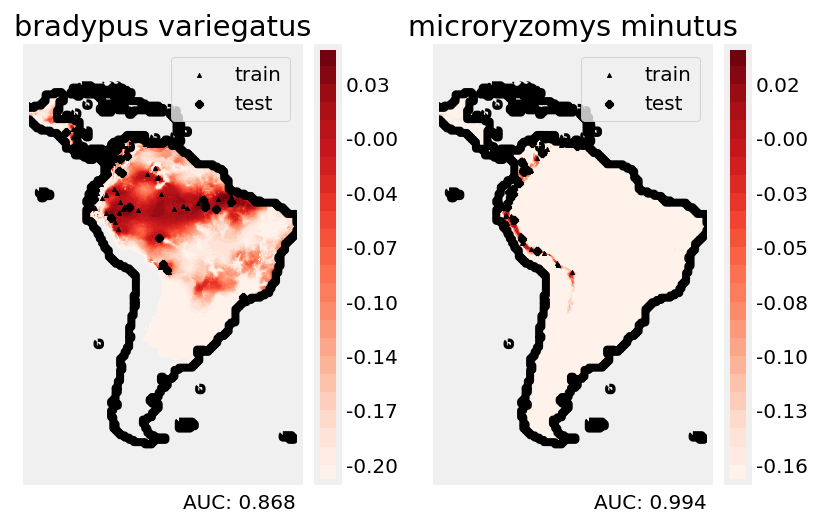

In [1]:
# Authors: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#          Jake Vanderplas <vanderplas@astro.washington.edu>
#
# License: BSD 3 clause

from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9998], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

NameError: name 'NaturalEarthFeature' is not defined

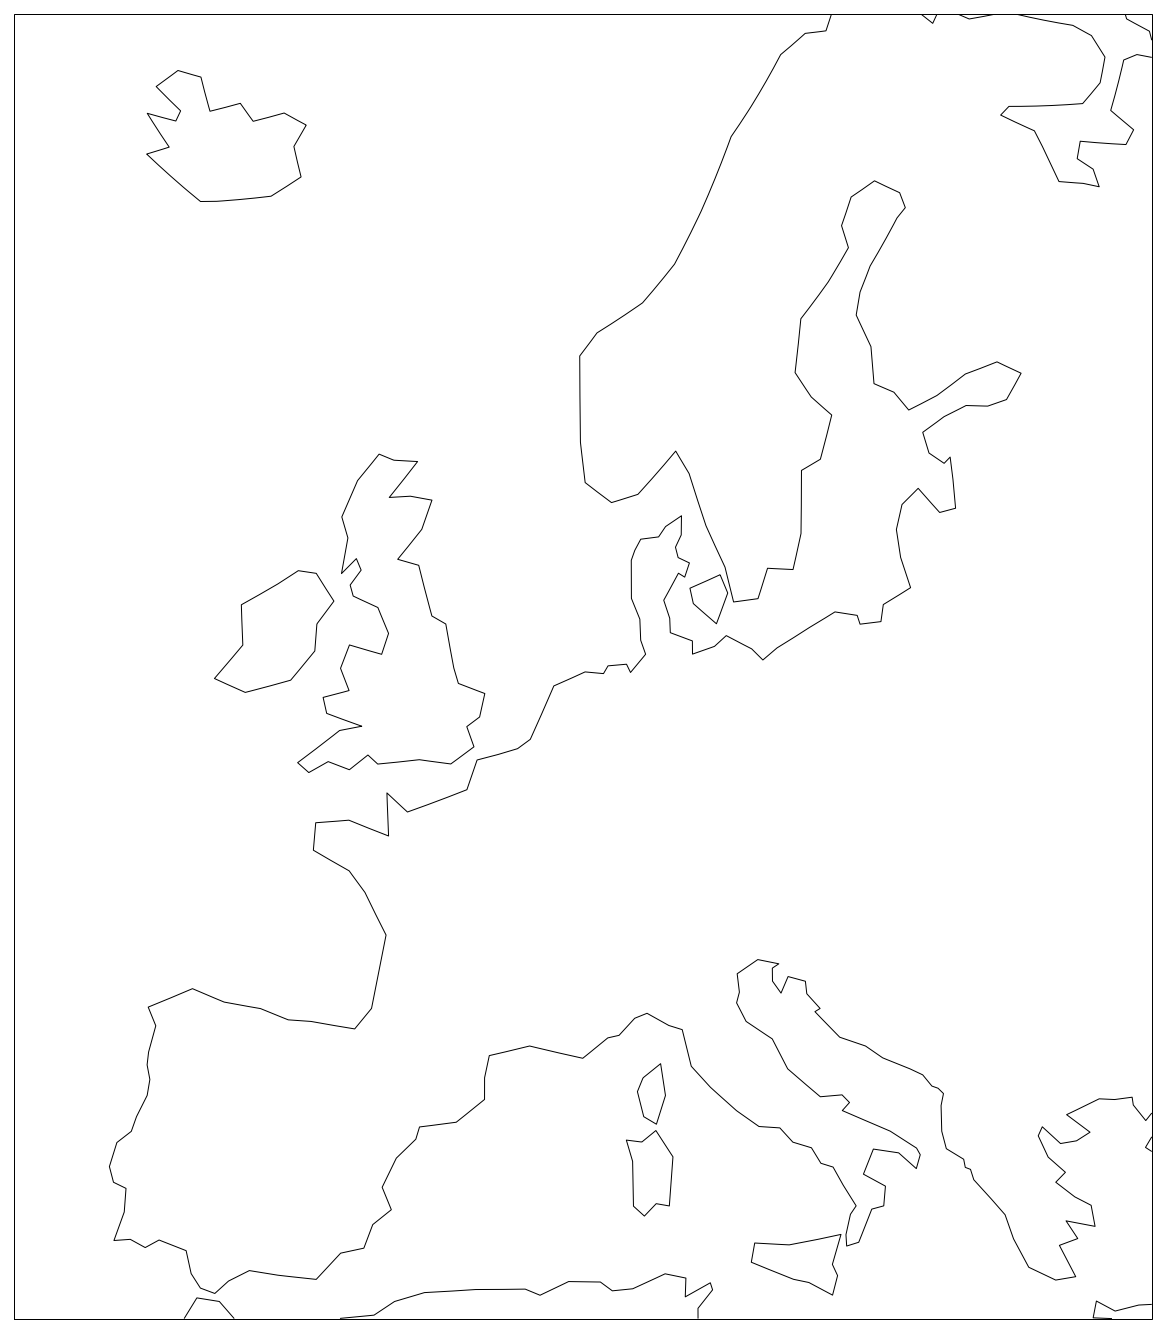

<Figure size 1440x864 with 0 Axes>

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


def main():
    fig = plt.figure(figsize=[20,12])
    plt.figure(figsize=[20,12])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
    ax.set_extent([-1400000.0, 2000000.0,4000000.0, 7900000.0],crs=ccrs.EuroPP())

#     ax.add_feature(cfeature.LAND)
#     ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(NaturalEarthFeature('physical','admin_0_boundary_lines_land'))
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.LAKES, alpha=0.5)
#     ax.add_feature(cfeature.RIVERS)
#     ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.gridlines()
    ax.natural_earth_shp()
    ax.coastlines(resolution='110m', color='black', linewidth=1)
    ax.stock_img()
#     ax.set_xlim([10,10])
#     ax.set_ylim([10,10])
    plt.show()


if __name__ == '__main__':
    main()

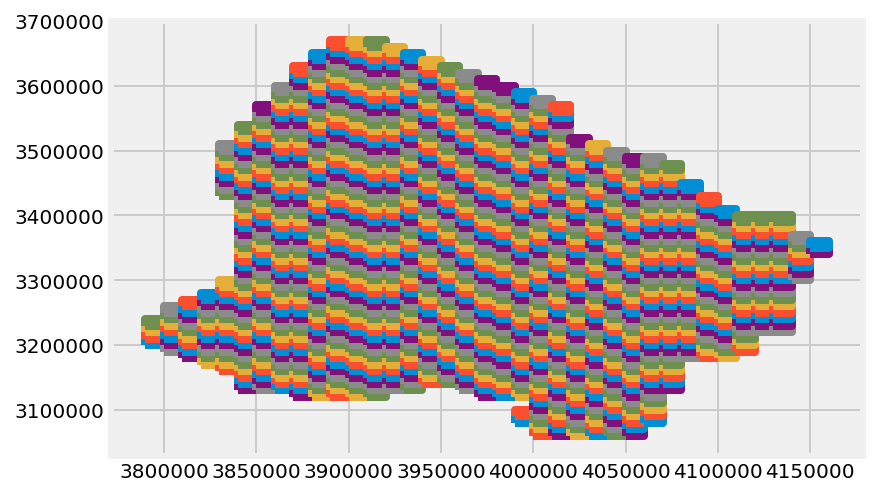

In [12]:
# https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib

import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader("/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

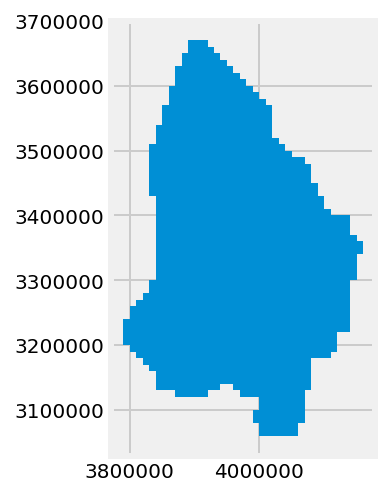

In [119]:
fp = "/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [120]:
shape_ex = sf.shape(5)

In [121]:
x_lon = np.zeros((len(shape_ex.points),1))

In [122]:
y_lat = np.zeros((len(shape_ex.points),1))
for ip in range(len(shape_ex.points)):
    x_lon[ip] = shape_ex.points[ip][0]
    y_lat[ip] = shape_ex.points[ip][1]
# plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])

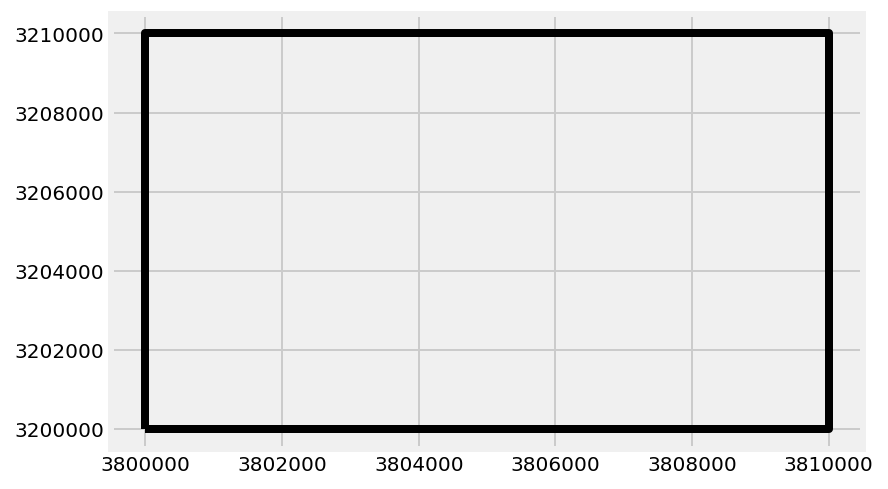

In [123]:
plt.plot(x_lon,y_lat,'k')

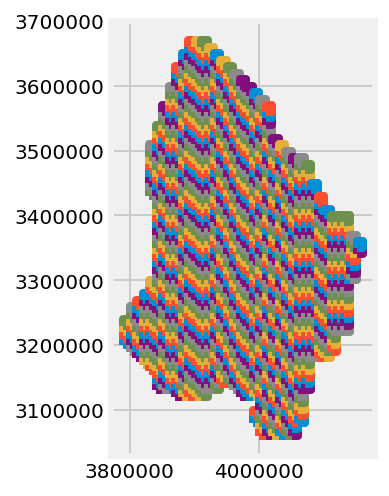

In [124]:
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')
for shape in list(sf.iterShapes()):
   x_lon = np.zeros((len(shape.points),1))
   y_lat = np.zeros((len(shape.points),1))
   for ip in range(len(shape.points)):
       x_lon[ip] = shape.points[ip][0]
       y_lat[ip] = shape.points[ip][1]

   plt.plot(x_lon,y_lat)


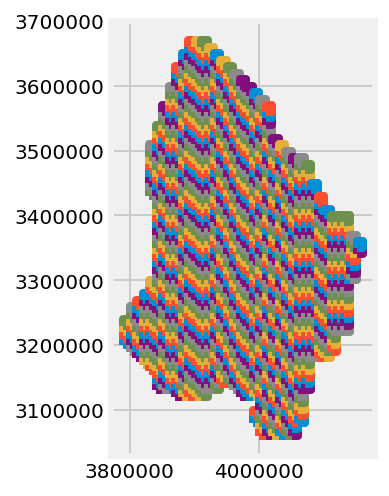

In [125]:
plt.figure()
ax = plt.axes() # add the axes
ax.set_aspect('equal')

for shape in list(sf.iterShapes()):
    npoints=len(shape.points) # total points
    nparts = len(shape.parts) # total parts

    if nparts == 1:
       x_lon = np.zeros((len(shape.points),1))
       y_lat = np.zeros((len(shape.points),1))
       for ip in range(len(shape.points)):
           x_lon[ip] = shape.points[ip][0]
           y_lat[ip] = shape.points[ip][1]
       plt.plot(x_lon,y_lat)

    else: # loop over parts of each shape, plot separately
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = npoints
                
            seg=shape.points[i0:i1+1]
            x_lon = np.zeros((len(seg),1))
            y_lat = np.zeros((len(seg),1))
            for ip in range(len(seg)):
                x_lon[ip] = seg[ip][0]
                y_lat[ip] = seg[ip][1]

            plt.plot(x_lon,y_lat)

# plt.xlim(-130,-60)
# plt.ylim(23,50)
plt.show()

In [126]:
# load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [127]:
!pip install geopandas

In [128]:
fp = '/Users/maartenk/Documents/git/Cookbooks/Sources/BAG-Woonplaatsgrenzen.shp'
# fp = "/Users/maartenk/Documents/git/Cookbooks/Sources/nl_10km.shp"
fp_ = '/Users/maartenk/Documents/git/Cookbooks/Sources/nl_imergis_kustlijn_2018.shp'
fp__ ='/Users/maartenk/Documents/git/Cookbooks/Sources/ESRI-PC4-2017R1.shp'

map_df = gpd.read_file(fp)
map_df_ = gpd.read_file(fp_)
map_df__ = gpd.read_file(fp__)

In [90]:
map_df.shape

(5, 6)

In [110]:
map_df__.head()

OBJECTID   PC4  Aantal_mul  Aantal_adr    Shape_Leng    Shape_Area  \
0       1.0  1011           1        7466   5908.190943  1.034025e+06   
1       2.0  1012           1        9261   5489.203939  1.214502e+06   
2       3.0  1013           2       15159  19421.006995  5.075544e+06   
3       4.0  1014           4        1640  15355.645043  2.674418e+06   
4       5.0  1015           1       11274   4732.836386  7.704063e+05   

                                            geometry  
0  POLYGON ((122246.2320000008 487910.1770000011,...  
1  POLYGON ((121995.0291999988 488243.2021000013,...  
2  (POLYGON ((120506.2192000002 489494.5513000004...  
3  (POLYGON ((120390.1125999987 489860.7457000017...  
4  POLYGON ((120665.6422999986 488535.5, 120668.7...

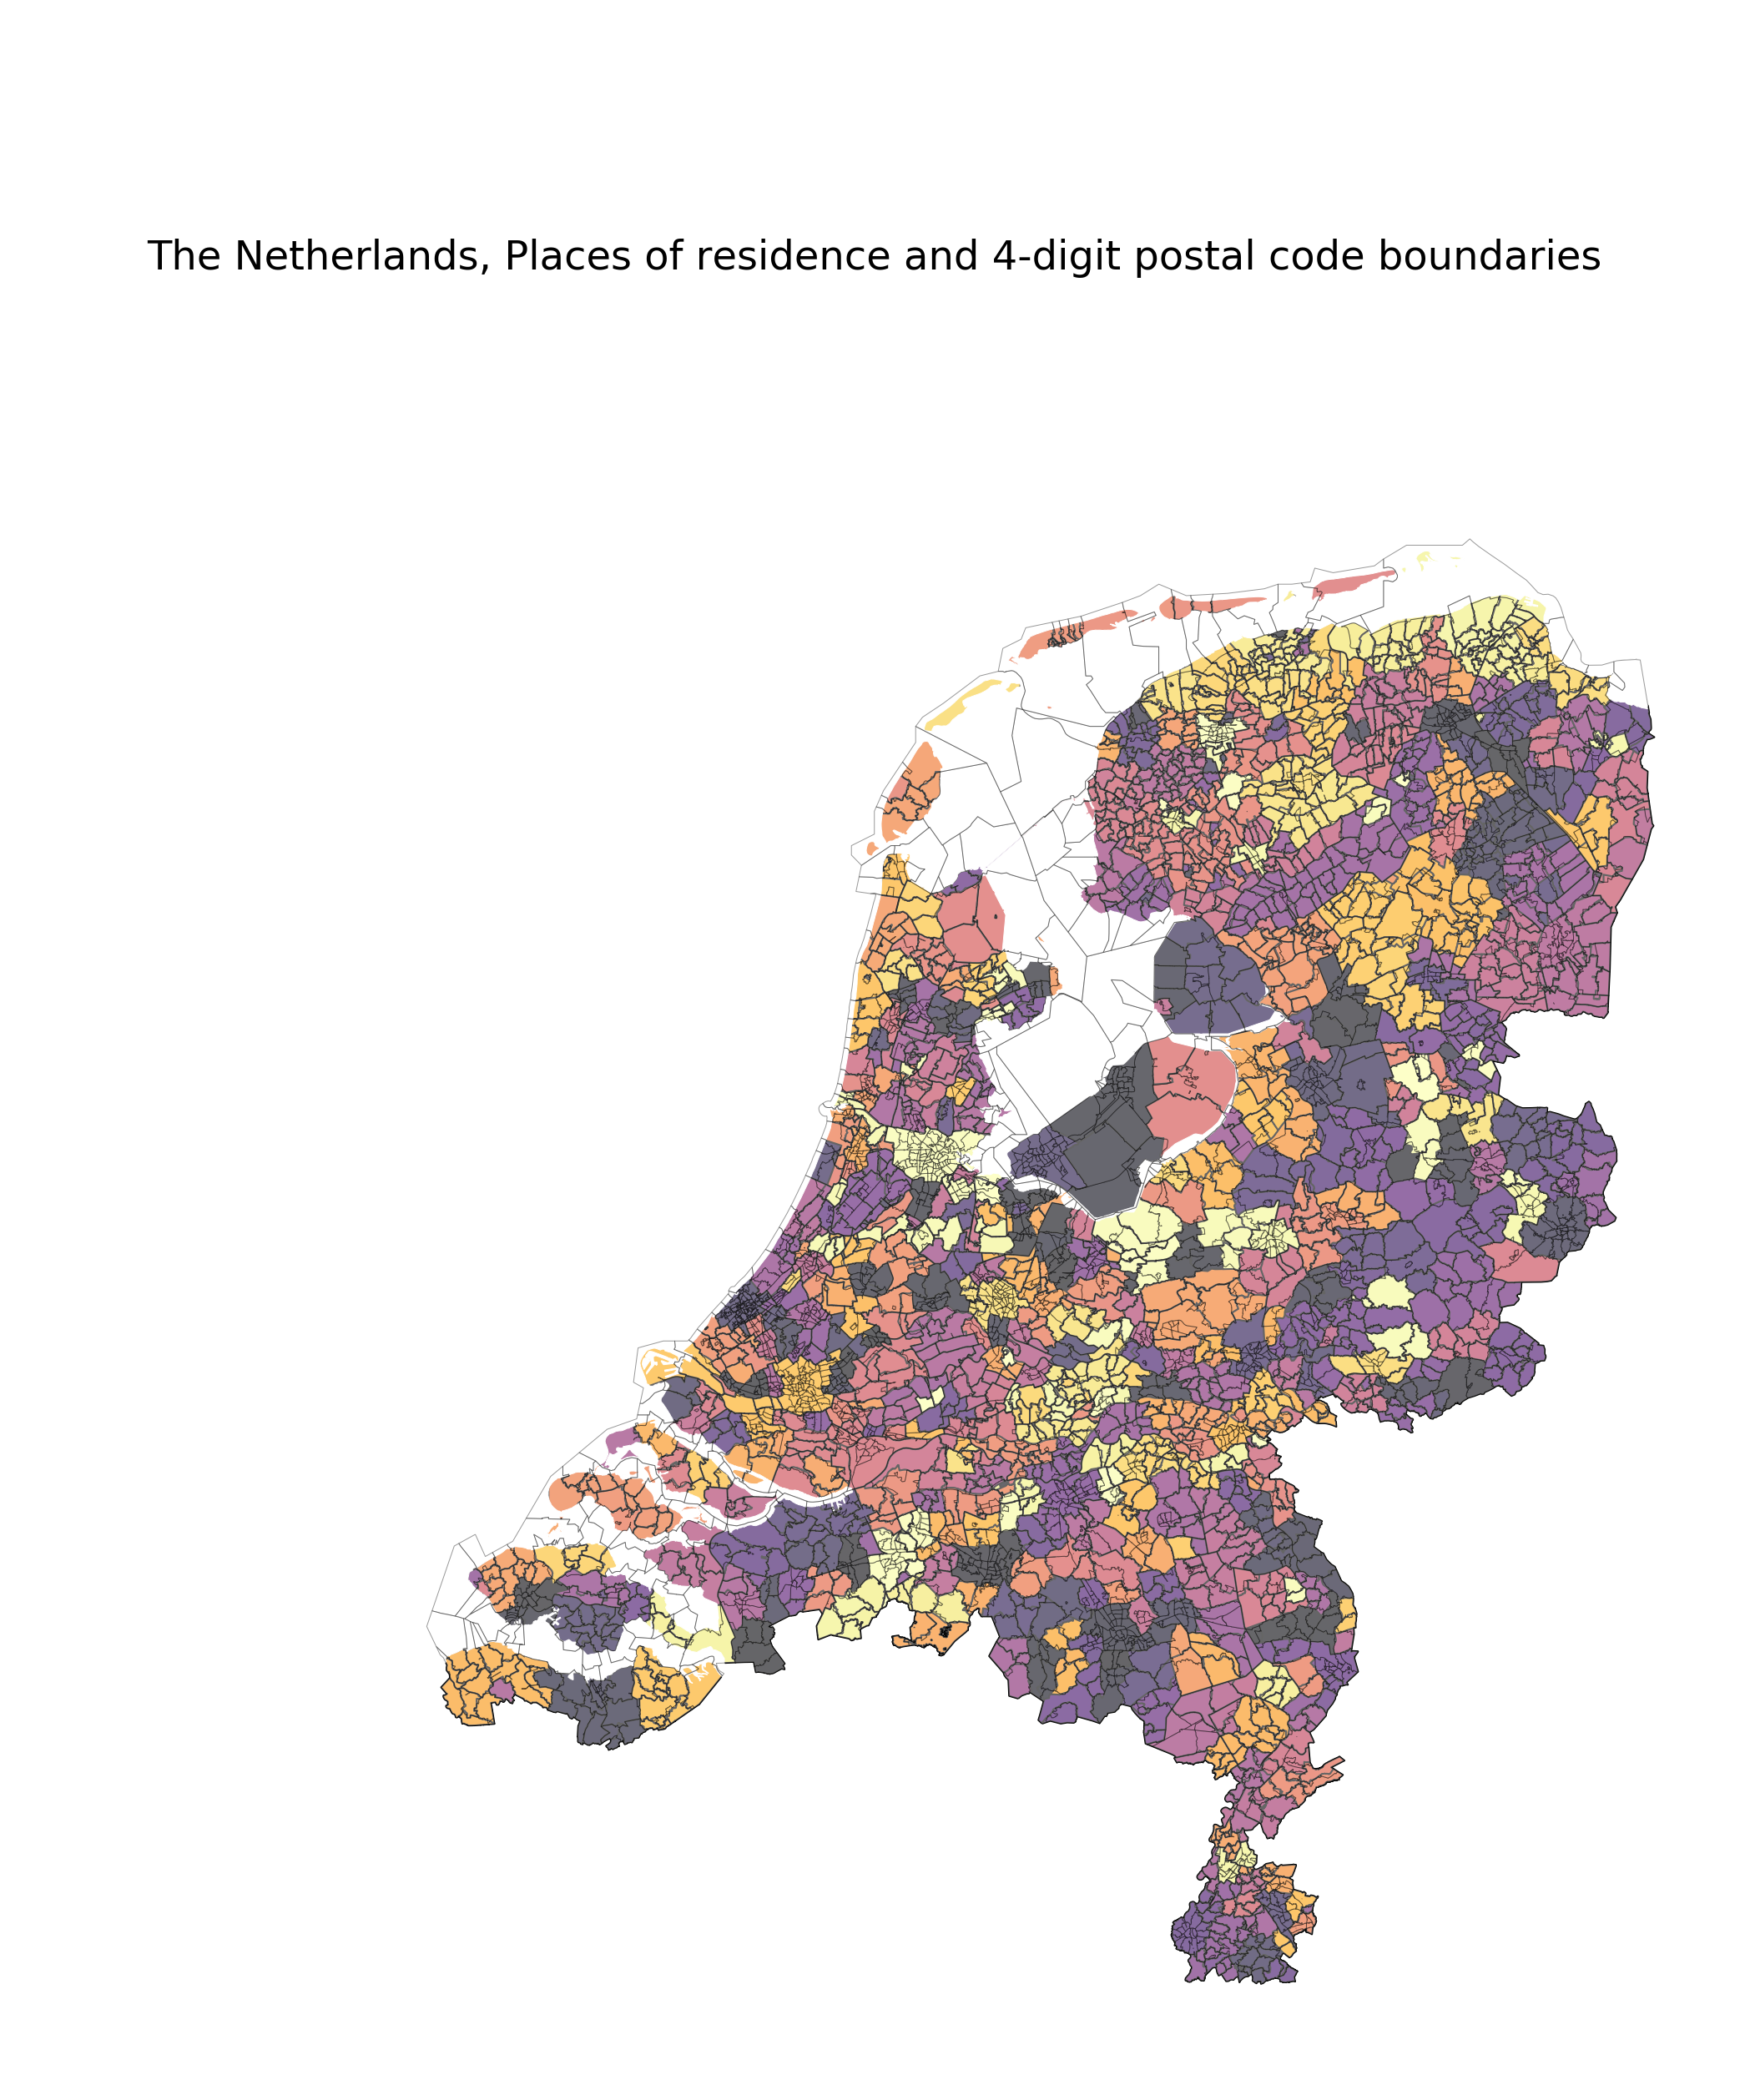

In [158]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes()
ax.set_aspect('equal')
ax.set_axis_off()
# ax.axis('equal')
# ax.axis('off')
map_df.plot(cmap='inferno',ax=ax, linewidth=1, edgecolor="black")
map_df_.plot(edgecolor='white', facecolor='white',ax=ax)
map_df__.plot(ax=ax, alpha=.4, edgecolor='black', facecolor='white')
fig.suptitle("\n\n\n\n\nThe Netherlands, Places of residence and 4-digit postal code boundaries", fontsize=24)
plt.show()

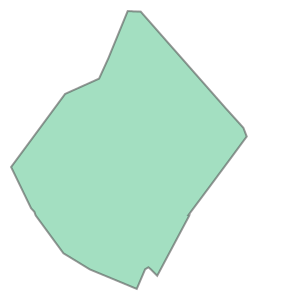

In [117]:
map_df.loc[5, 'geometry']

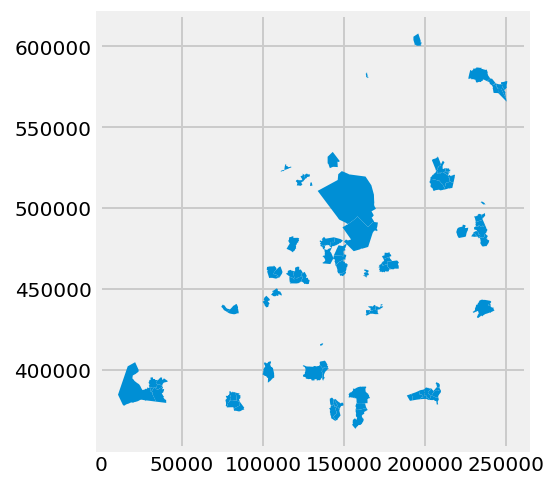

In [172]:
map_df.loc[0:100].plot();

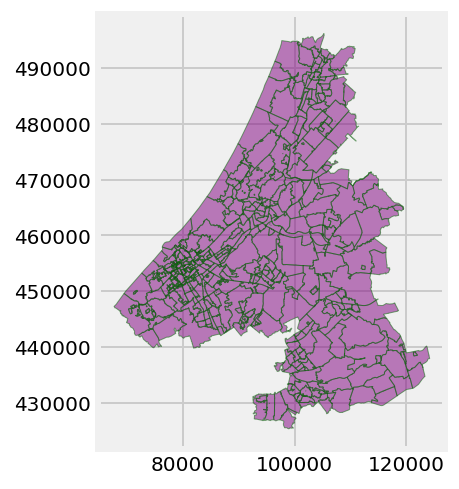

In [176]:
map_df__.loc[(map_df__['PC4'].astype(int) > 1999) & (map_df__['PC4'].astype(int) < 2999), ].plot(facecolor='purple', edgecolor='darkgreen', alpha=.5)

In [164]:
map_df__.dtypes

OBJECTID      float64
PC4            object
Aantal_mul      int64
Aantal_adr      int64
Shape_Leng    float64
Shape_Area    float64
geometry       object
dtype: object

In [178]:
roads = '/Users/maartenk/Documents/git/Cookbooks/Sources/nwb-light.shp'

map_df_roads = gpd.read_file(roads)


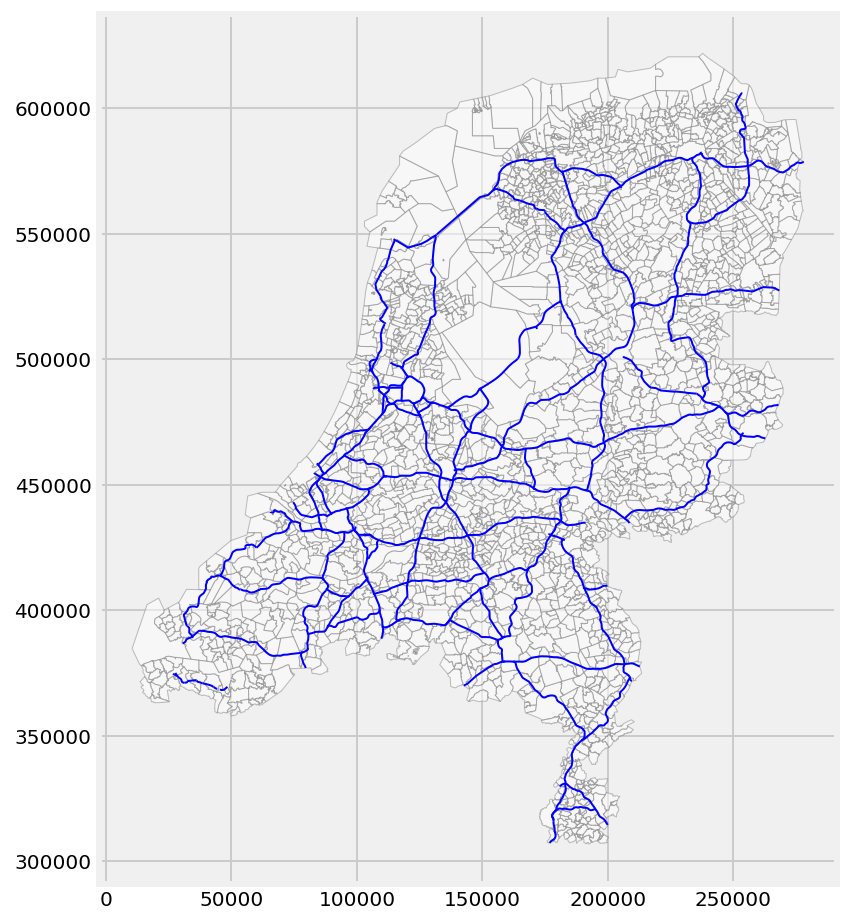

In [195]:
fig, ax = plt.subplots(1,figsize=(8,8))
map_df.plot(ax=ax, facecolor='white', edgecolor='grey', alpha=.5)
map_df_roads.loc[map_df_roads['BEHEERDER']=='R'].plot(lw=1, color='blue', ax=ax)

In [222]:
map_df__.crs

{'init': 'epsg:28992'}

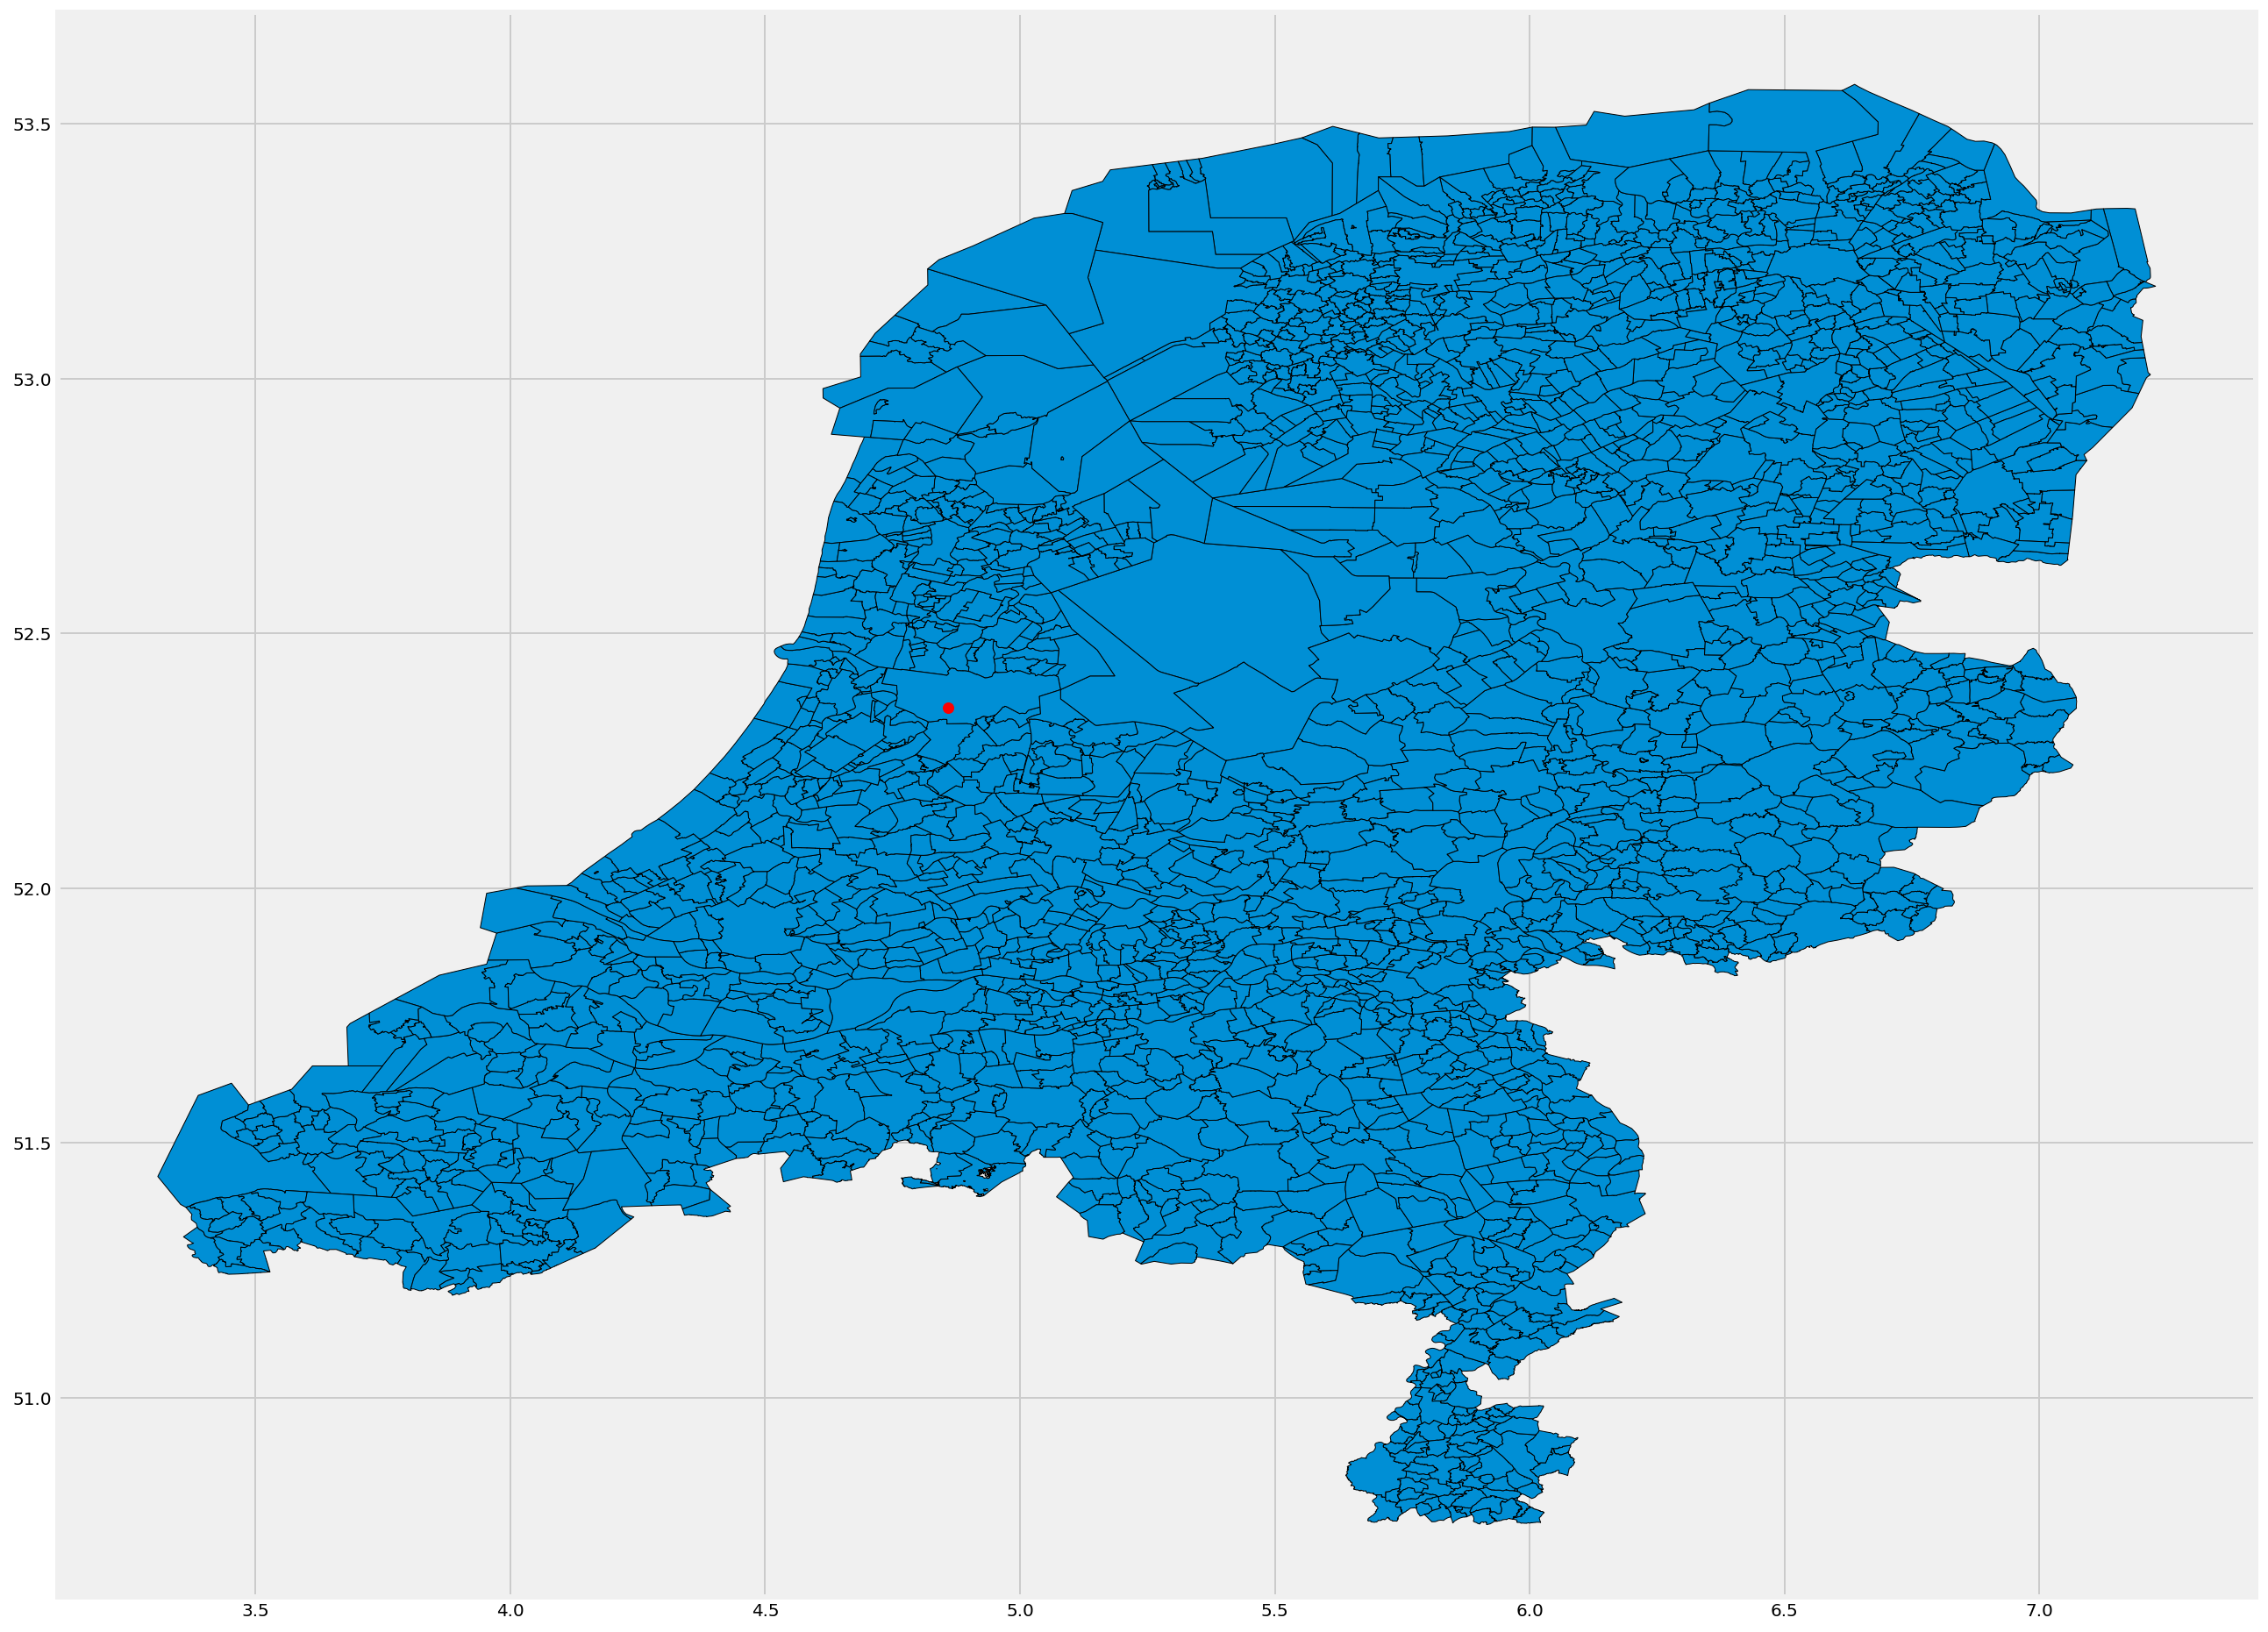

In [244]:
map_df.to_crs(epsg=4289).plot(figsize=(20,20), edgecolor='black')
lon=52.3545653,
lat=4.8585408
plt.scatter(lat,lon, c='r')
# plt.axis('equal')

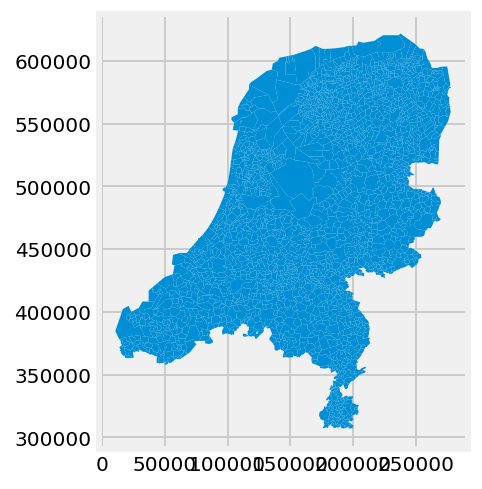

In [221]:
lat=52.3545653,
lon=4.7585408
lims=map_df.to_crs(epsg=28992).plot()
# plt.axis('equal')

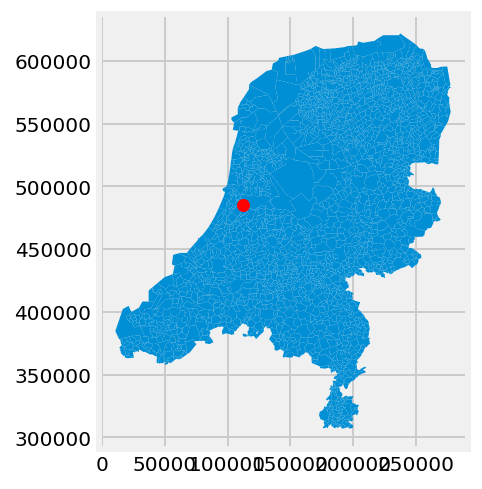

In [219]:
map_df.plot()
plt.scatter(112170, 485370, color='red')

In [246]:
cbs = '/Users/maartenk/Documents/git/Cookbooks/Sources/CBS_PC4_2017_v1.shp'

map_df_cbs = gpd.read_file(cbs)



No handles with labels found to put in legend.


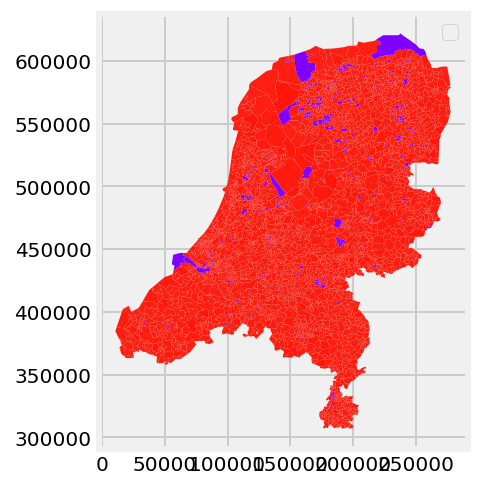

In [253]:
map_df_cbs.plot(column='UITKMINAOW', cmap='rainbow')
plt.legend()